<a href="https://colab.research.google.com/github/viniciusrpb/cic0193_machine_learning/blob/main/cap12_4_sentiment_analysis_lstm_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 12 - Transformers


### Tarefa: classificação de polaridade em tweets

Classificar um *tweet* em alguma das três polaridades: positiva (*positive*), negativa (*negative*) e positiva (*neutral*).

Fonte (TensorFlow Hub):

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

### O *corpus*

Para isso, vamos precisar utilizar as bibliotecas keras, tensorflow, numpy, sklearn, matplotlib.

Fonte: [SemEval-2013 Task 2: Sentiment Analysis in Twitter](https://aclanthology.org/S13-2052/)

O *corpus* de tweets empregado nesse estudo de caso podem ser acessados na pasta "corpus_tweets" deste repositório. Segue a especificação de cada arquivo:

*   ```twitter-2013train-A.txt```: conjunto de tweets para treinamento
*   ```twitter-2013dev-A.txt```: conjunto de tweets para validação
*   ```twitter-2013test-A.txt```: conjunto de tweets para testes

In [1]:
!pip install -U keras
!pip install -U tensorflow
!pip install transformers
!pip install tensorflow_text
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 462 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 4.7 MB/s 
     |████████████████████████████████| 895 kB 28.8 MB/s 
     |████████████████████████████████| 6.5 MB 35.2 MB/s 
     |████████████████████████████████| 596 kB 12.1 MB/s 
     |████████████████████████████████| 77 kB 2.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 5.2 MB/s 


Importando as classes necessárias a partir das bibliotecas

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Dense,Activation,Input,LSTM,Bidirectional,Dropout,SpatialDropout1D
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import transformers
print(transformers.__version__)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.layers.embeddings import Embedding

4.18.0


### Carregamento do corpus para Pandas DataFrames



**PS.:** Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse [link](https://machinelearningmastery.com/difference-test-validation-datasets/).


In [3]:
path_train = 'twitter-2013train-A.txt'
path_valid = 'twitter-2013dev-A.txt'
path_test = 'twitter-2013test-A.txt'

In [4]:
df_train = pd.read_csv(path_train, names=["id","polarity","text"],encoding='utf8', sep='\t')
df_valid = pd.read_csv(path_valid, names=["id","polarity","text"],encoding='utf8', sep='\t')
df_test = pd.read_csv(path_test, names=["id","polarity","text"],encoding='utf8', sep='\t')

In [5]:
df_train

,id,polarity,text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...
...,...,...,...
9679,103158179306807296,positive,RT @MNFootNg It's monday and Monday Night Foot...
9680,103157324096618497,positive,All I know is the road for that Lomardi start ...
9681,100259220338905089,neutral,"All Blue and White fam, we r meeting at Golden..."
9682,104230318525001729,positive,@DariusButler28 Have a great game agaist Tam...


Informações sobre cada parte do *corpus* de tweets:

In [6]:
print(f"O conjunto de treinamento possui {df_train.shape[0]} tweets")
print(f"O conjunto de validação possui {df_valid.shape[0]} tweets")
print(f"O conjunto de testes possui {df_test.shape[0]} tweets")

O conjunto de treinamento possui 9684 tweets
O conjunto de validação possui 1654 tweets
O conjunto de testes possui 3547 tweets


### Pré-processamento dos Tweets

Remove o atributo **id**, pois não será necessário o uso desse atributo no processo de classificação.



In [7]:
df_train.drop(labels=['id'],axis=1)
df_valid.drop(labels=['id'],axis=1)
df_test.drop(labels=['id'],axis=1)

,polarity,text
0,positive,"@jjuueellzz down in the Atlantic city, ventnor..."
1,positive,Musical awareness: Great Big Beautiful Tomorro...
2,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,negative,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,neutral,"Excuse the connectivity of this live stream, f..."
...,...,...
3542,negative,Khaleda Zia's present India visit may have a b...
3543,neutral,"FYI, golf fans: @jameslepp will join Moj on We..."
3544,negative,@__Aniko you think mr.Calle let practice with ...
3545,positive,Don't hide under your desk! It's just a salsa ...


Além disso, por questões do uso dos métodos da classe Sequential no Keras-Tensorflow, convertemos o atributo de classe para o tipo categórico e para cada instância, mapeamos seus valores para números inteiros. Lembre-se que os **modelos de aprendizado de máquina processam apenas números inteiros ou reais**.

In [8]:
df_train['polarity'] = pd.Categorical(df_train['polarity'])
df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
df_test['polarity'] = pd.Categorical(df_test['polarity'])

y_train = df_train['polarity'].cat.codes
y_valid = df_valid['polarity'].cat.codes
y_test = df_test['polarity'].cat.codes

Vamos ver como e repare que o mapeamento do atributo categórico "polarity" para valores categóricos inteiros ficou como:

*   polaridade "negativa" *(negative)*: valor $0$
*   polaridade "neutra" *(neutral)*: valor $1$
*   polaridade "positiva" *(positive)*: valor $2$

In [9]:
for i in range(0,5):
    v = df_train['polarity'][i]
    print(f'Valor original da classe {v} Transformação inteira: {y_train[i]}')

Valor original da classe positive Transformação inteira: 2
Valor original da classe negative Transformação inteira: 0
Valor original da classe negative Transformação inteira: 0
Valor original da classe negative Transformação inteira: 0
Valor original da classe neutral Transformação inteira: 1


A seguir, transformamos os valores da classe "polaridade", nossa classe de interesse, para one-hot-encoding. Nessa representação, como temos três classes, utilizaremos três bits, em que para cada instância, apenas um deles estará ativado (com valor $1$) com base na presença do valor classe.

Veja como fica a representação one-hot encoding para cada classe:

*   polaridade "negativa" *(negative)*: valor $0$, one hot encoding: $[1,0,0]$
*   polaridade "neutra" *(neutral)*: valor $1$, one hot encoding: $[0,1,0]$
*   polaridade "positiva" *(positive)*: valor $2$, one hot encoding: $[0,0,1]$

Utilizaremos a função *to_categorical* do Keras para esse propósito (se bem que poderíamos facilmente implementar uma por nossa conta):

In [10]:
from keras.utils.np_utils import to_categorical

num_classes = 3

y_train_enc = to_categorical(y_train,3)
y_valid_enc = to_categorical(y_valid,3)
y_test_enc = to_categorical(y_test,3)

Apenas verificando como ficou o pré-processamento do atributo de classe:

In [11]:
for i in range(0,5):
    v = df_train['polarity'][i]
    print(f"Tweet {i}: valor original da classe '{v}'; mapeamento para inteiro: {y_train[i]}; representação one-hot-encoding [{int(y_train_enc[i][0])},{int(y_train_enc[i][1])},{int(y_train_enc[i][2])}]")

Tweet 0: valor original da classe 'positive'; mapeamento para inteiro: 2; representação one-hot-encoding [0,0,1]
Tweet 1: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 2: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 3: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 4: valor original da classe 'neutral'; mapeamento para inteiro: 1; representação one-hot-encoding [0,1,0]


### Extração de características dos tweets

 Bidirectional Encoder Representations from Transformers (BERT). The BERT architecture is composed of several Transformer encoders stacked together. Further, each Transformer encoder is composed of two sub-layers: a feed-forward layer and a self-attention layer.

 Primeiramente, fazemos os downloads do modelo BERT de referência:


In [12]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [13]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

Colocamos as instâncias (juntamente com seus vetores BERT) nas respectivas matrizes $X$ (para cada tipo de dados), em que cada linha de $X$ está associada a um *tweet*. Repare que as classes (labels, rótulos etc) já foram separadas anteriormente e estão armazenadas nas variáveis ```y```. Por exemplo, a instância de treinamento $\mathbf{x_i}$, denotada por ```X_train[i]``` é da classe ```y_train[i]``` $\in \{0,1,2\}$.

In [14]:
X_train = df_train['text'].values
X_valid = df_valid['text'].values
X_test = df_test['text'].values

In [15]:
X_train[0]

'Gas by my house hit $3.39!!!! I\\u2019m going to Chapel Hill on Sat. :)'

In [16]:
sample = [X_train[0]]
text_preprocessed = bert_preprocess(sample)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 3806 2011 2026 2160 2718 1002 1017 1012 4464  999  999]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.8057022  -0.44450736 -0.55610144  0.6081395   0.03992073 -0.09596545
  0.69608736  0.33400092 -0.37008688 -0.9999634   0.11522834  0.7892676 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.15877226  0.1460731   0.43972343 ... -0.31484985  0.3212449
   0.31777155]
 [ 0.65560526 -0.18834352  1.0243313  ... -0.44978327  0.01051322
   0.29176   ]
 [ 0.13443717 -0.35418344  1.087825   ... -0.7229347  -0.14338884
   0.23410942]
 ...
 [-0.07321975  0.24194658  0.11324732 ... -0.40200403  0.5916259
  -0.3293868 ]
 [ 0.25970036  0.30408114  1.3485484  ...  0.17821038 -0.11198954
  -0.10162394]
 [ 0.46989918  0.

In [17]:
vocab_size = 128

### Modelo de Classificação: BERT Input + LSTM + Sigmoid Function





In [18]:
num_neurons = 64
num_embeddings = 128

In [22]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
model = Model(text_input, net)

In [36]:
inputs = model.inputs[:2]
bert_out = model.output
newReshape = tf.keras.layers.Reshape((768,1), name='newReshape')(bert_out)
#bert_out.shape

In [37]:
lstm = LSTM(256)(newReshape)
newout = Dense(768,activation='relu')(lstm)
preds = Dense(num_classes, activation='sigmoid')(newout)
model = Model(inputs, preds)

O ajuste do modelo para o treinamento consiste em utilizarmos um otimizador da classe SGD (*Stochastic Gradient Descent*), em que colocamos aleatoriamente um valor da taxa de aprendizado ```learning_rate=0.001```.

Outra alteração se trata da função *loss* (que calcula o erro da modelo). Como temos um problema de classificação multiclasse, temos que empregar a função ```categorical_crossentropy```.

In [38]:
#sgd = SGD(learning_rate=3e-5)

adam = Adam(learning_rate=0.00001,decay = 1e-6)

model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=['accuracy'])
history_fine = model.fit(X_train,y_train_enc,validation_data=(X_valid,y_valid_enc),epochs=10)

Epoch 1/10
303/303 [==============================] - 606s 2s/step - loss: 0.9471 - accuracy: 0.6301 - val_loss: 0.7768 - val_accuracy: 0.6524
Epoch 2/10
303/303 [==============================] - 581s 2s/step - loss: 0.6377 - accuracy: 0.7244 - val_loss: 0.7282 - val_accuracy: 0.6524
Epoch 3/10
303/303 [==============================] - 581s 2s/step - loss: 0.5219 - accuracy: 0.7605 - val_loss: 0.7426 - val_accuracy: 0.6499
Epoch 4/10
303/303 [==============================] - 581s 2s/step - loss: 0.4304 - accuracy: 0.8052 - val_loss: 0.7921 - val_accuracy: 0.7128
Epoch 5/10
303/303 [==============================] - 581s 2s/step - loss: 0.3522 - accuracy: 0.8869 - val_loss: 0.8244 - val_accuracy: 0.7316
Epoch 6/10
303/303 [==============================] - 581s 2s/step - loss: 0.2883 - accuracy: 0.9153 - val_loss: 0.8650 - val_accuracy: 0.7364
Epoch 7/10
303/303 [==============================] - 580s 2s/step - loss: 0.2215 - accuracy: 0.9327 - val_loss: 0.8485 - val_accuracy: 0.7455

Vamos analisar o comportamento da função *loss* no decorrer das épocas:

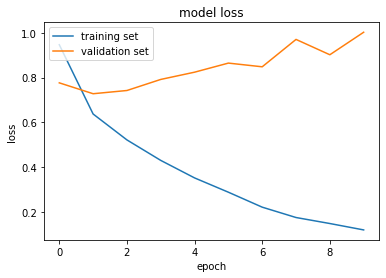

In [39]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']


plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

O comportamento acima das curvas de loss mostra que o modelo aprende bem os padrões dos dados de treinamento, ganhando mais confiança nas suas classificações. Já a curva para os dados de validação (desconhecidos para o treinamento do modelo) mostram que a *loss* se estabiliza após algumas épocas.

**O que fazer para melhorar?**

Dá para fazer muita coisa...

*   Otimização dos hiperparâmetros: altere a quantidade de camadas intermediárias, a quantidade de neurônios em cada camada intermediária, a quantidade de épocas de treinamento, o algoritmo de otimização (veja [aqui](https://keras.io/api/optimizers/) outros otimizadores);
*   Etapas de pré-processamento dos *tweets*: remoção de URLs, @'s, etc...
*   A caracterização dos *tweets* (por exemplo, o [BERT](https://keras.io/examples/nlp/text_extraction_with_bert/)!)...


### Avaliação de performance utilizando os dados de teste

Agora fazemos a classificação das instâncias do conjunto de teste utilizando o método *predict*. Observe que uma matriz é gerada na saída, em que cada linha representa um *tweet* e as colunas representam:


*   Coluna $0$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "0" (polaridade negativa)
*   Coluna $1$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "1" (polaridade neutra)
*   Coluna $2$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "2" (polaridade positiva)



In [40]:
y = model.predict(X_test)
y

array([[0.2264621 , 0.8613842 , 0.40541023],
       [0.34821957, 0.4485632 , 0.70630455],
       [0.03780433, 0.99058   , 0.27396843],
       ...,
       [0.22388306, 0.93936676, 0.25324726],
       [0.05695976, 0.20156829, 0.9876643 ],
       [0.0455583 , 0.98867524, 0.27305946]], dtype=float32)

De maneira genérica, podemos calcular argmax das probabilidades, tomando-se as colunas como referência. Suponha que todas as probabilidades estejam na variável ```y_prob```, em que cada linha se trata de uma instância e teremos três colunas:

*   ```y_prob[i][0]```: estimativa da probabilidade de classificar a $i$-ésima instância  de ```X_test``` como sendo da classe "0"
*   ```y_prob[i][1]```: estimativa da probabilidade de classificar a $i$-ésima instância de ```X_test``` como sendo da classe "1"
*   ```y_prob[i][2]```: estimativa da probabilidade de classificar a $i$-ésima instância de ```X_test``` como sendo da classe "2"

Assim, com o uso de $argmax$, para cada instância $i$ podemos obter o índice $j$ da coluna associada à classe com a maior probabilidade:

In [41]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)

Vamos imprimir os resultados da classificação de *tweets* para os dados de teste:

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       559
           1       0.74      0.82      0.78      1513
           2       0.83      0.75      0.79      1475

    accuracy                           0.77      3547
   macro avg       0.77      0.76      0.76      3547
weighted avg       0.78      0.77      0.77      3547



Outra possibilidade é o uso do método *evaluate*:



In [44]:
print(model.evaluate(X_test,y_test_enc))

111/111 [==============================] - 77s 696ms/step - loss: 0.9379 - accuracy: 0.7745
[0.9379117488861084, 0.7744572758674622]
